In [1]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [2]:
print(iris_data.DESCR)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [3]:
features = iris_data.data
labels = iris_data.target

In [4]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

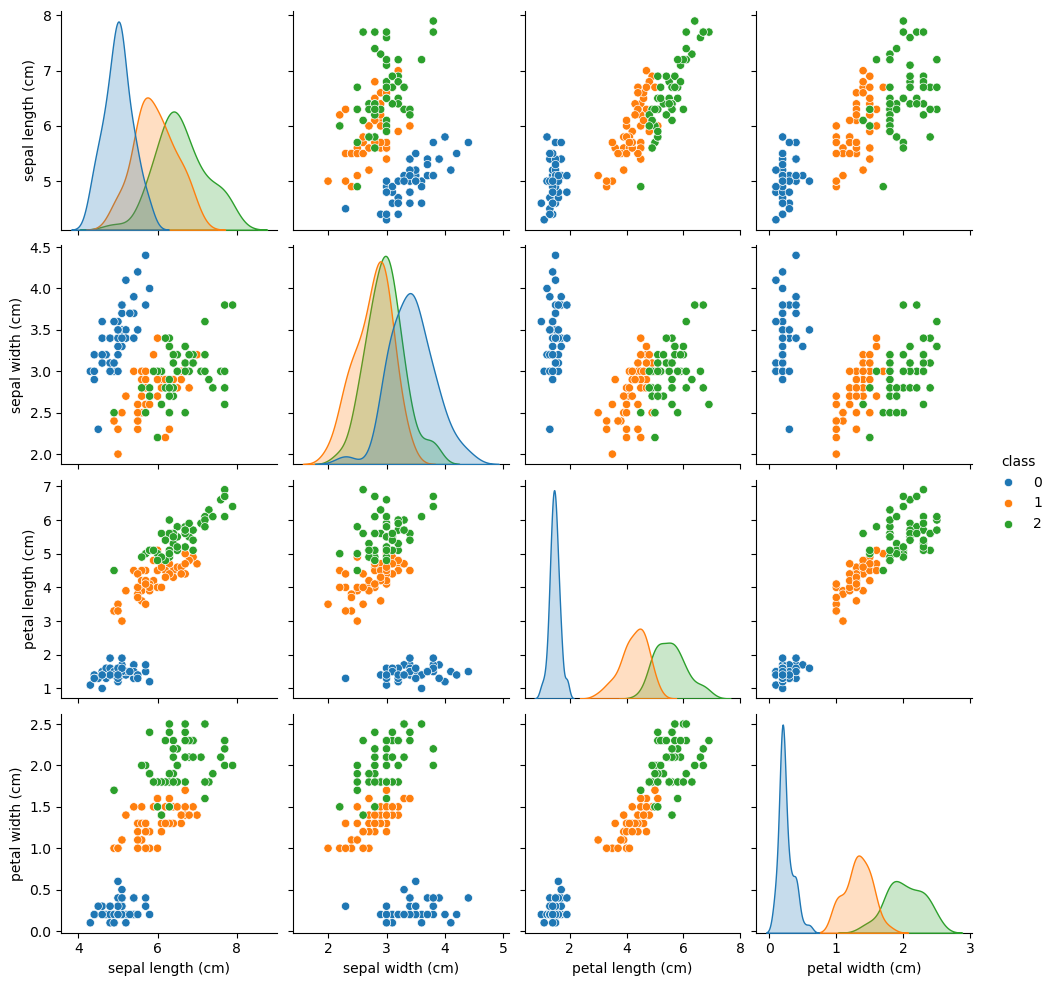

In [5]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

In [6]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [7]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [8]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


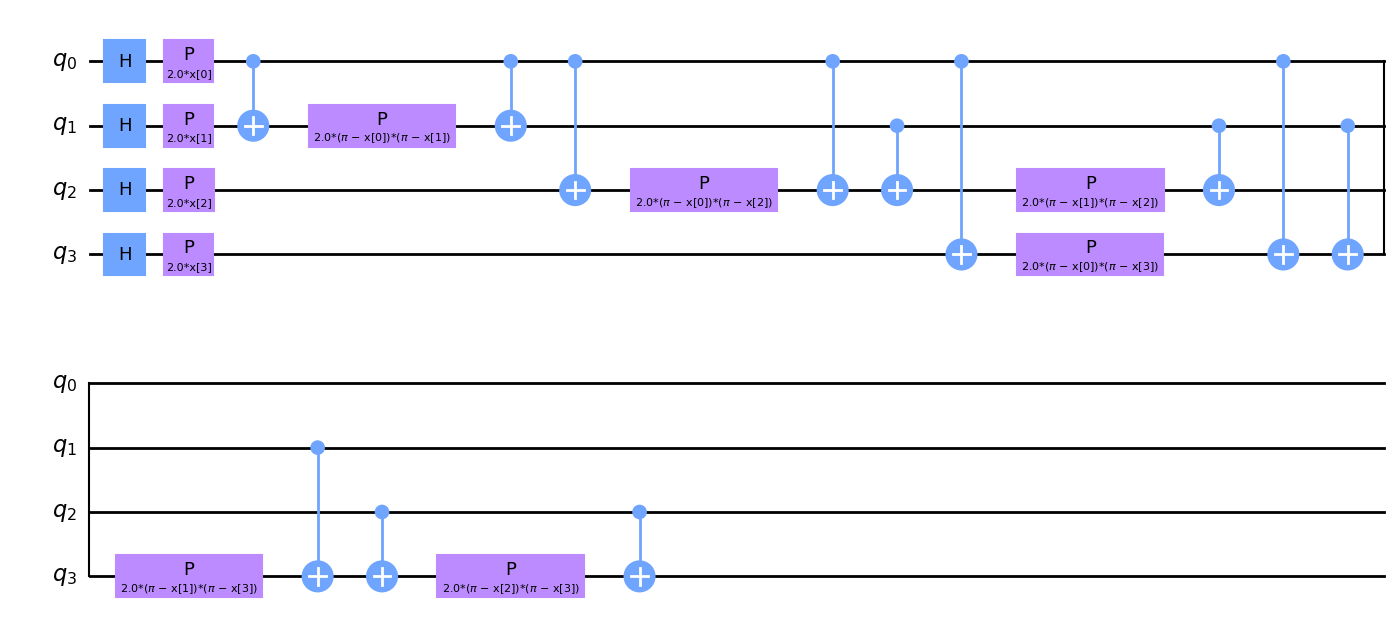

In [9]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

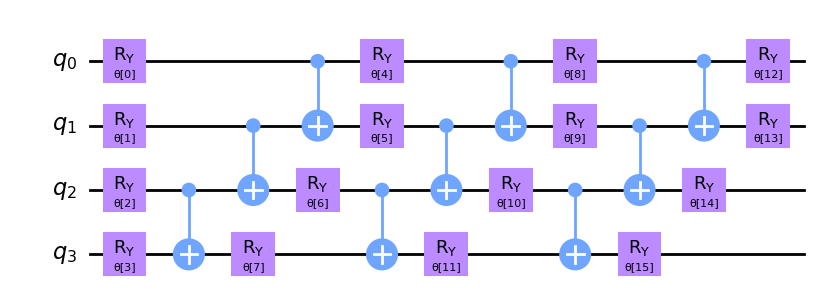

In [10]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [11]:
from qiskit_machine_learning.optimizers import COBYLA

optimizer = COBYLA(maxiter=200)

In [12]:
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()

In [13]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [14]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [15]:
train_features0 = train_features
test_features0 = test_features


In [16]:
import numpy as np
train_features = train_features0
test_features = test_features0

# Min-max scaling function with training stats
def minmax_scale_to_pi_train_test(data, train_min, train_max):
    scaled_data = (data - train_min) / (train_max - train_min)  # Scale to [0, 1]
    scaled_data = scaled_data - 0.5
    scaled_data = scaled_data * np.pi * 2/6
    #scaled_data = scaled_data * np.pi * 1/2

    return scaled_data
    

# Compute min and max from training data
train_min = np.min(train_features, axis=0)
train_max = np.max(train_features, axis=0)
# Print to verify the range
print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

# Scale training and test data
train_features = minmax_scale_to_pi_train_test(train_features, train_min, train_max)
test_features = minmax_scale_to_pi_train_test(test_features, train_min, train_max)
print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )



train range: 0.0 to 1.0  mean of  0.45401757689893274
test range: 0.0 to 0.9661016949152543  mean of  0.42739524482109226
train range: -0.5235987755982988 to 0.5235987755982988  mean of  -0.05237229137260893
test range: -0.5535187056324875 to 0.488100553523838  mean of  -0.08051951133370897


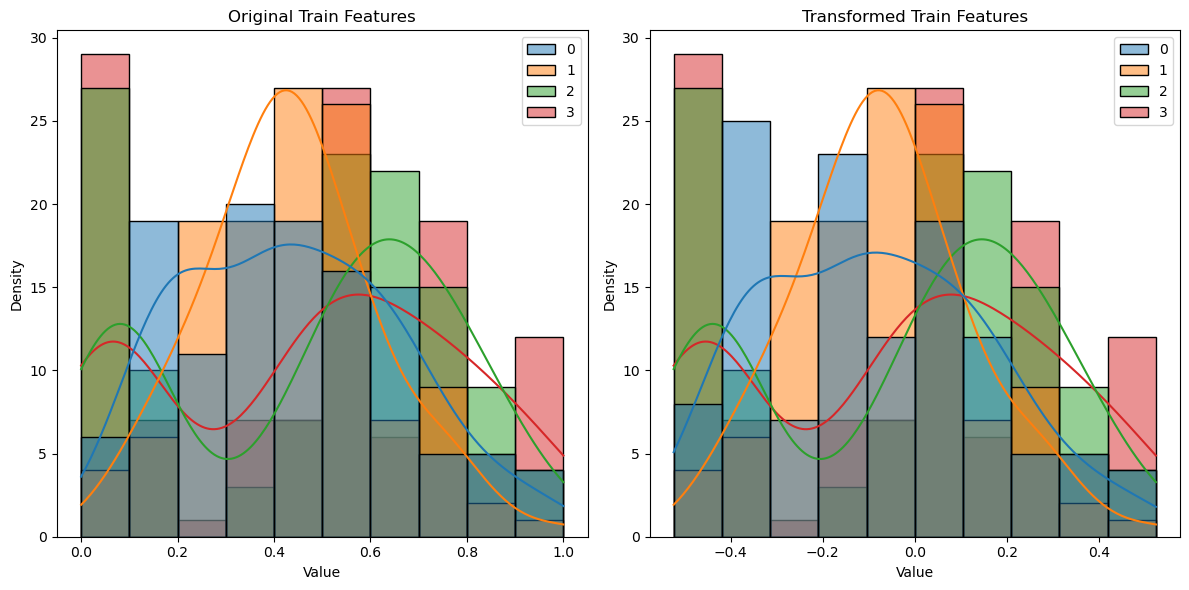

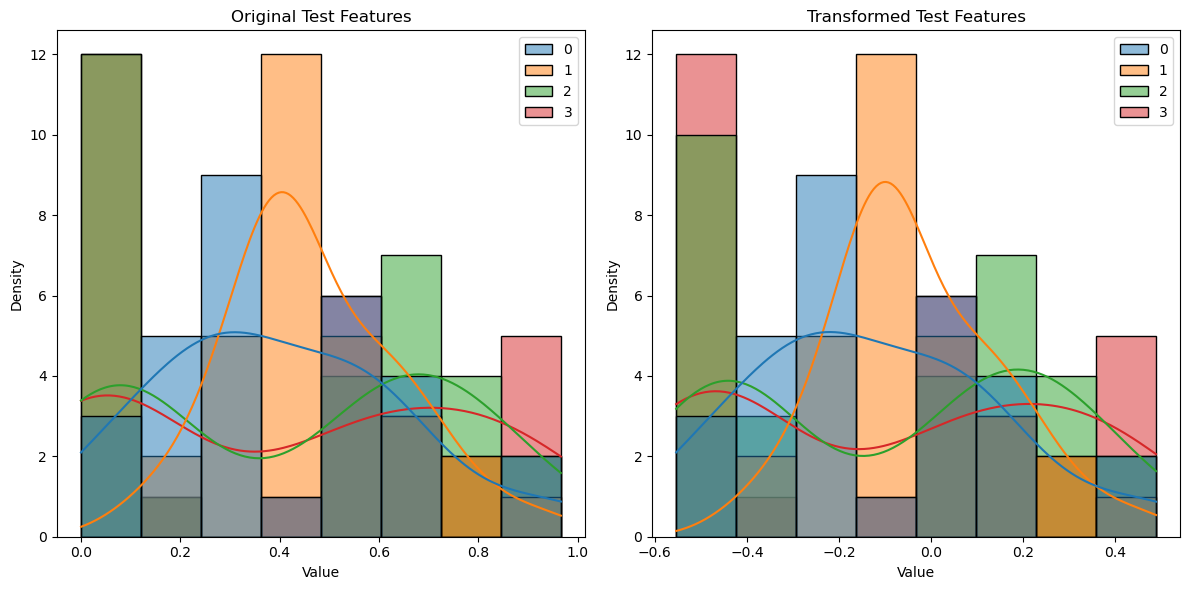

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of train_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(train_features0, kde=True, color='blue', label='Original Train Features')
plt.title('Original Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(train_features, kde=True, color='green', label='Transformed Train Features')
plt.title('Transformed Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Plot the distribution of test_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(test_features0, kde=True, color='blue', label='Original Test Features')
plt.title('Original Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(test_features, kde=True, color='green', label='Transformed Test Features')
plt.title('Transformed Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [18]:
idx = train_features > np.mean(train_features)
#train_features[idx] = train_features[idx] + np.pi / 3
train_features[idx] = train_features[idx] + np.pi / 4 # Pretty good

# since mean is negative, will do equal to negative
idx = train_features <= np.mean(train_features)
train_features[idx] = train_features[idx] - np.pi / 4

idx = test_features > np.mean(test_features)
test_features[idx] = test_features[idx] + np.pi / 4
# since mean is negative, will do equal to negative
idx = test_features <= np.mean(test_features)
test_features[idx] = test_features[idx] - np.pi / 4

print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

train range: -1.308996938995747 to 1.308996938995747  mean of  0.00980506322968906
test range: -1.3389168690299358 to 1.2734987169212864  mean of  -0.09360948072366643


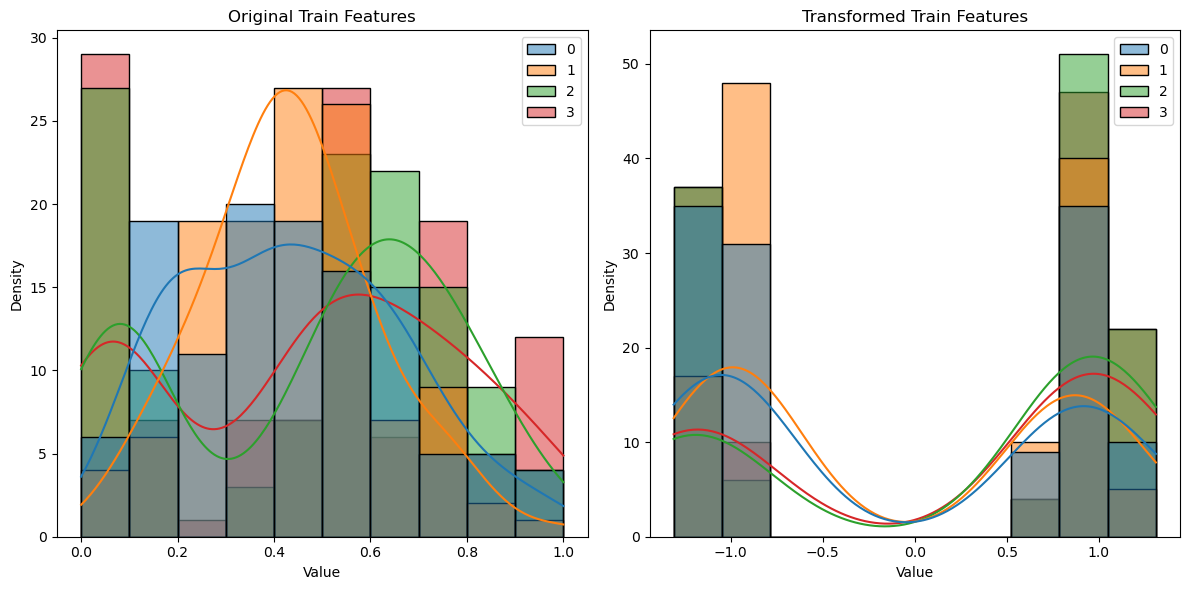

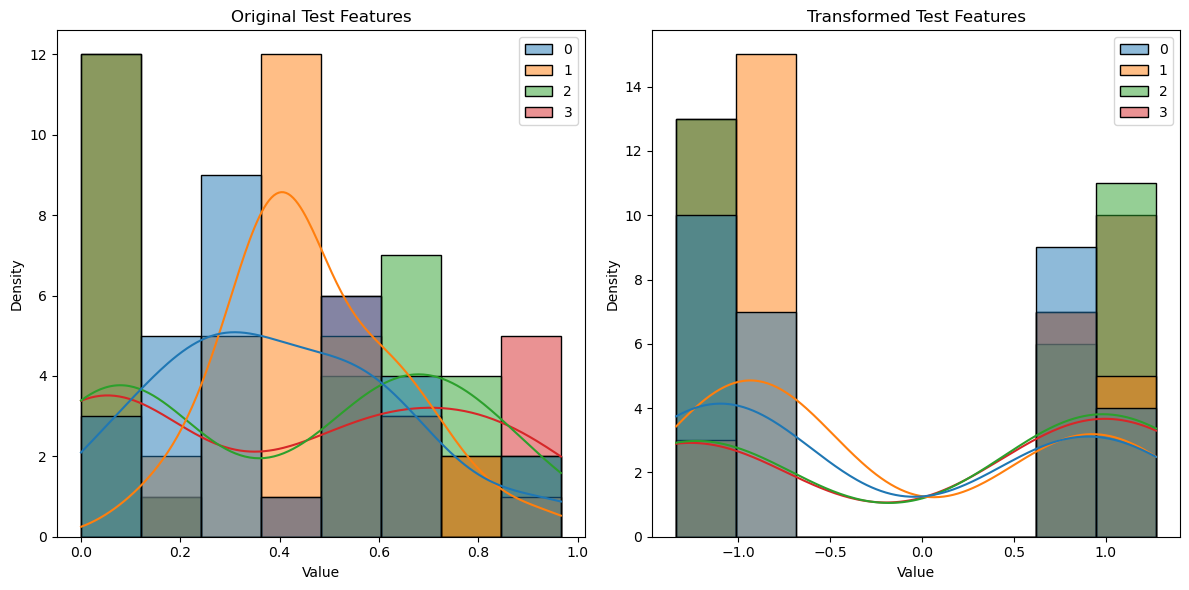

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of train_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(train_features0, kde=True, color='blue', label='Original Train Features')
plt.title('Original Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(train_features, kde=True, color='green', label='Transformed Train Features')
plt.title('Transformed Train Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Plot the distribution of test_features
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(test_features0, kde=True, color='blue', label='Original Test Features')
plt.title('Original Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

# Transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(test_features, kde=True, color='green', label='Transformed Test Features')
plt.title('Transformed Test Features')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

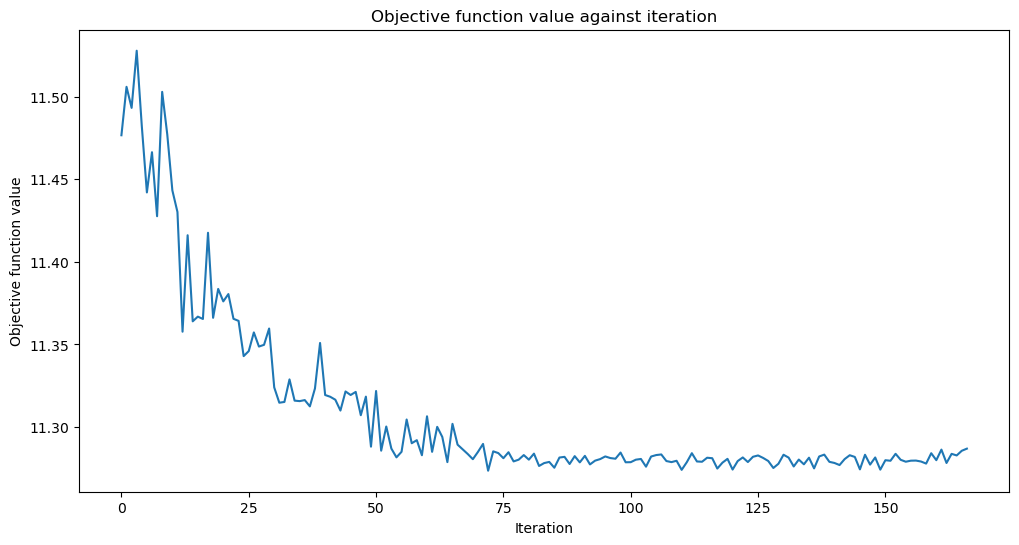

Training time: 111 seconds


In [151]:
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [20]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

QiskitMachineLearningError: 'The model has not been fitted yet'

<Axes: >

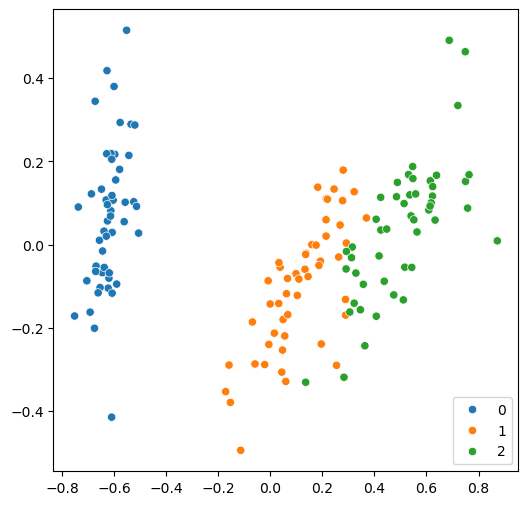

In [21]:
# Reducing the Number of Features
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [22]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score_c2 = svc.score(train_features, train_labels)
test_score_c2 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c2:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c2:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


In [23]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

optimizer = COBYLA(maxiter=40)


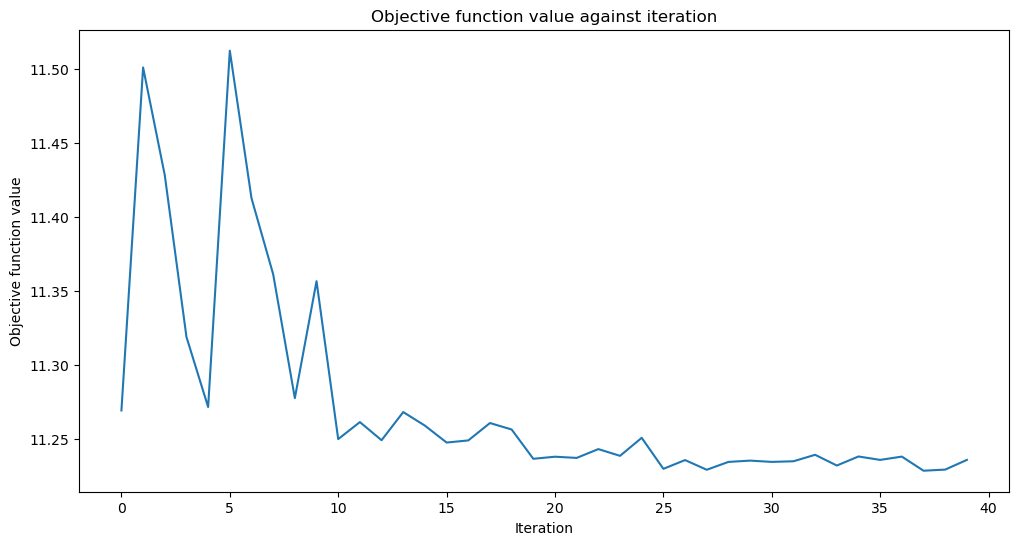

Training time: 19 seconds


In [24]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [26]:
train_score_q2_ra = vqc.score(train_features, train_labels)
test_score_q2_ra = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.50
Quantum VQC on the test dataset using RealAmplitudes:     0.37


In [28]:
from sklearn.datasets import load_iris

iris_data = load_iris()

features = iris_data.data
labels = iris_data.target

In [29]:
# #from sklearn.preprocessing import MinMaxScaler
# #features = MinMaxScaler().fit_transform(features)

# # from sklearn.preprocessing import StandardScaler
# # scaled_data =  StandardScaler().fit_transform(data) 

# # from sklearn.preprocessing import RobustScaler
# # features = RobustScaler().fit_transform(features) 
# import numpy as np
# from sklearn.preprocessing import StandardScaler

# def scale_data(data, train_data=None):
#   """
#   Scales data using a combination of:
#     1. Standardization (mean centering and unit variance)
#     2. Min-Max scaling to the range [-pi/2, pi/2] 
#     3. Shifting data points to be within [-3*pi/4, -pi/4] and [pi/4, 3*pi/4]

#   Args:
#     data: The data to be scaled (numpy array).
#     train_data: If provided, scaling parameters (mean and standard deviation) 
#                 are calculated from train_data and applied to both train_data and data.

#   Returns:
#     Scaled data.
#   """

#   # Print min, max, and mean of the original data
#   print(f"Min before: {np.min(data, axis=0)}")
#   print(f"Max before: {np.max(data, axis=0)}")
#   print(f"Mean before: {np.mean(data, axis=0)}")

#   if train_data is not None:
#     scaler = StandardScaler().fit(train_data)
#     data = scaler.transform(data)
#     train_data = scaler.transform(train_data) 
#   else:
#     scaler = StandardScaler().fit(data)
#     data = scaler.transform(data)

#   # Min-Max scaling to [-pi/2, pi/2]
#   data_min = np.min(data, axis=0)
#   data_max = np.max(data, axis=0)
#   data = (data - data_min) / (data_max - data_min) 
#   data = data - 0.5 
#   data = data * np.pi

#   # Shift data points to be within [-3*pi/4, -pi/4] and [pi/4, 3*pi/4]
#   mean = np.mean(data, axis=0)
#   data = np.where(data > mean, 
#                   np.clip(data, np.pi/3, 2*np.pi/3), 
#                   np.clip(data, -2*np.pi/3, -np.pi/3))

#   # Print min, max, and mean of the scaled data
#   print(f"Min: {np.min(data, axis=0)}")
#   print(f"Max: {np.max(data, axis=0)}")
#   print(f"Mean: {np.mean(data, axis=0)}")

#   return data

# features0 = features
# features = scale_data(features)


# import numpy as np
# from sklearn.preprocessing import StandardScaler

# def scale_data_three_partitions(data, train_data=None):
#     """
#     Scales data into three partitions:
#     1. Values above +1 standard deviation are scaled to [pi/3, 2*pi/3].
#     2. Values below -1 standard deviation are scaled to [-2*pi/3, -pi/3].
#     3. Values within -1 to +1 standard deviation are scaled to [-pi/4, pi/4].

#     Args:
#         data: The data to be scaled (numpy array).
#         train_data: Optional. If provided, the scaling parameters (mean and std) 
#                     are calculated from train_data and applied to data.

#     Returns:
#         Scaled data.
#     """
#     # Standardize the data
#     if train_data is not None:
#         scaler = StandardScaler().fit(train_data)
#         data = scaler.transform(data)
#     else:
#         scaler = StandardScaler().fit(data)
#         data = scaler.transform(data)

#     # Allocate the scaled data
#     scaled_data = np.zeros_like(data)
#     std = 0.5 # Define the standard deviation threshold

#     # Scale values above +1 std
#     above_std = data > std
#     scaled_data[above_std] = np.interp(
#         data[above_std], [std, np.max(data)], [np.pi / 3, 2 * np.pi / 3]
#     )

#     # Scale values below -1 std
#     below_std = data < -std
#     scaled_data[below_std] = np.interp(
#         data[below_std], [np.min(data), -std], [-2 * np.pi / 3, -np.pi / 3]
#     )

#     # Scale values within -1 to +1 std
#     within_std = (data >= -std) & (data <= std)
#     scaled_data[within_std] = np.interp(
#         data[within_std], [-std, std], [-np.pi *3 / 2, np.pi * 3 / 2]
#         #data[within_std], [-std, std], [-np.pi / 4, np.pi / 4]

#     )

#     return scaled_data

import numpy as np
from sklearn.preprocessing import StandardScaler

def scale_data_three_partitions(data, train_data=None):
    """
    Scales data into three partitions:
    1. Values above +1 standard deviation and below -1 standard deviation are scaled to [pi/3, 2*pi/3].
    2. Values within -1 to +1 standard deviation are scaled to [-2*pi/3, -pi/3].

    Args:
        data: The data to be scaled (numpy array).
        train_data: Optional. If provided, the scaling parameters (mean and std) 
                    are calculated from train_data and applied to data.

    Returns:
        Scaled data.
    """
    # Standardize the data
    if train_data is not None:
        scaler = StandardScaler().fit(train_data)
        data = scaler.transform(data)
    else:
        scaler = StandardScaler().fit(data)
        data = scaler.transform(data)

    # Allocate the scaled data
    scaled_data = np.zeros_like(data)
    std = 1.0  # Define the standard deviation threshold

    # Scale values above +1 std and below -1 std to [pi/3, 2*pi/3]
    extreme_values = (data > std) | (data < -std)
    scaled_data[extreme_values] = np.interp(
        data[extreme_values], [np.min(data), np.max(data)], [np.pi / 3, 2 * np.pi / 3]
    )

    # Scale values within -1 to +1 std to [-2*pi/3, -pi/3]
    within_std = (data >= -std) & (data <= std)
    scaled_data[within_std] = np.interp(
        data[within_std], [-std, std], [-2 * np.pi / 3, -np.pi / 3]
    )

    return scaled_data

features0 = features 
# Apply the three-partition scaling
features = scale_data_three_partitions(features)

#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1, 1))

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

#features = scaler.fit_transform(features)

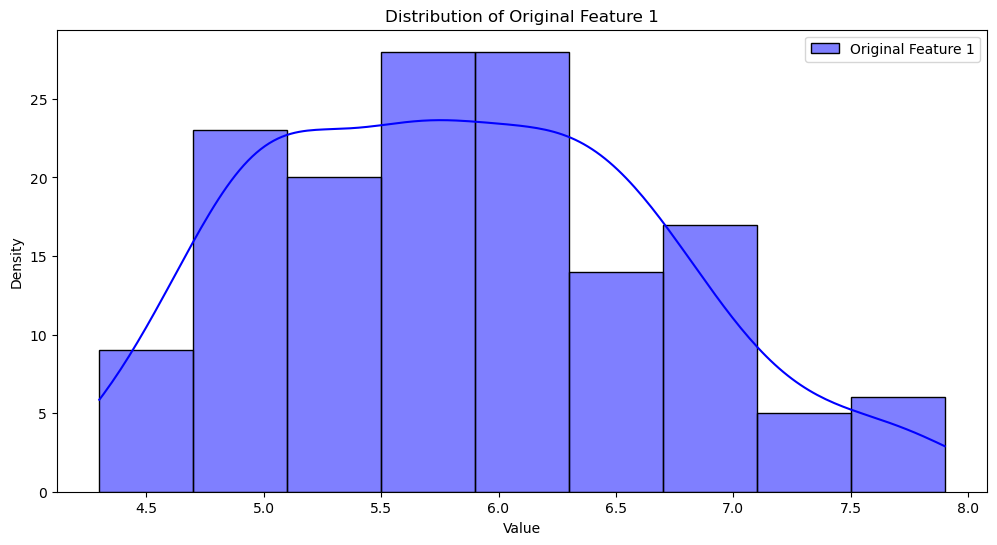

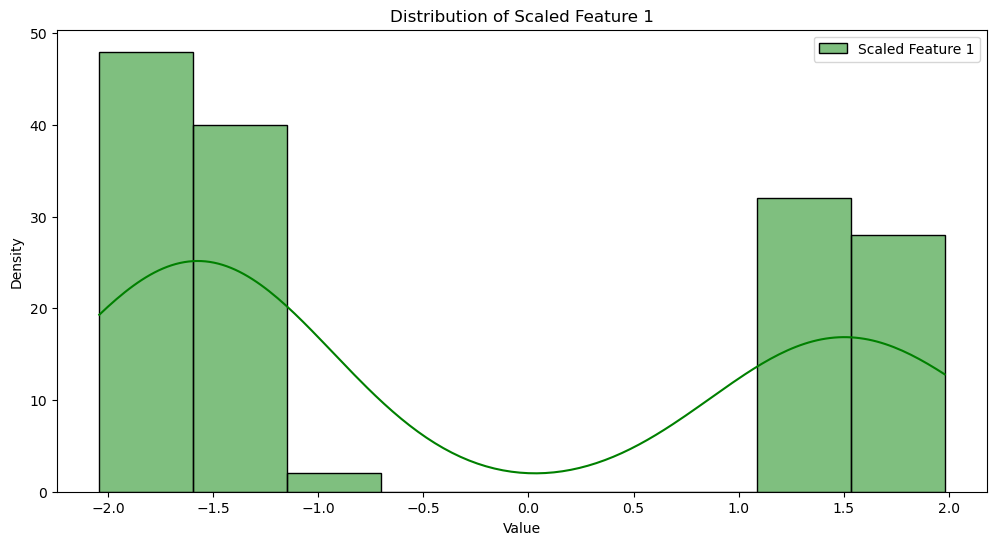

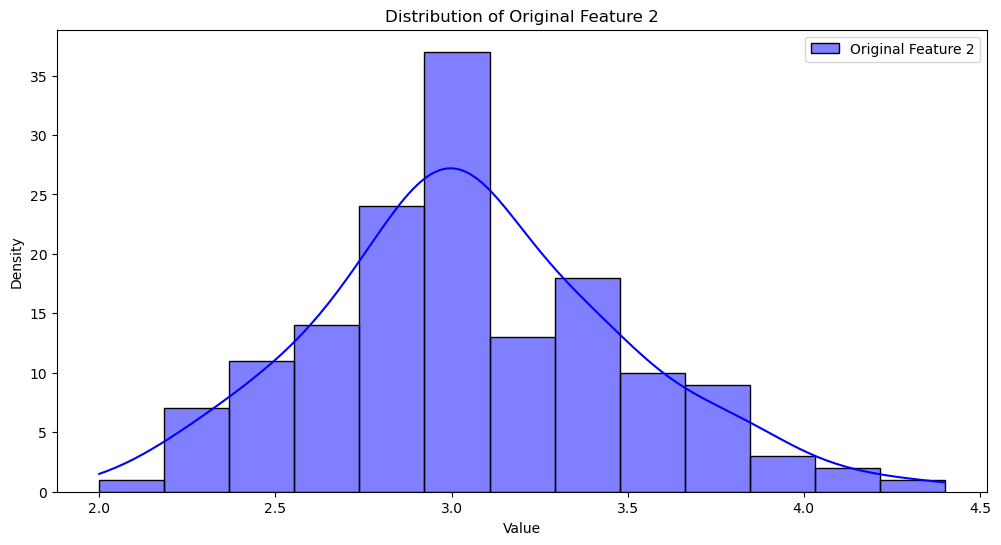

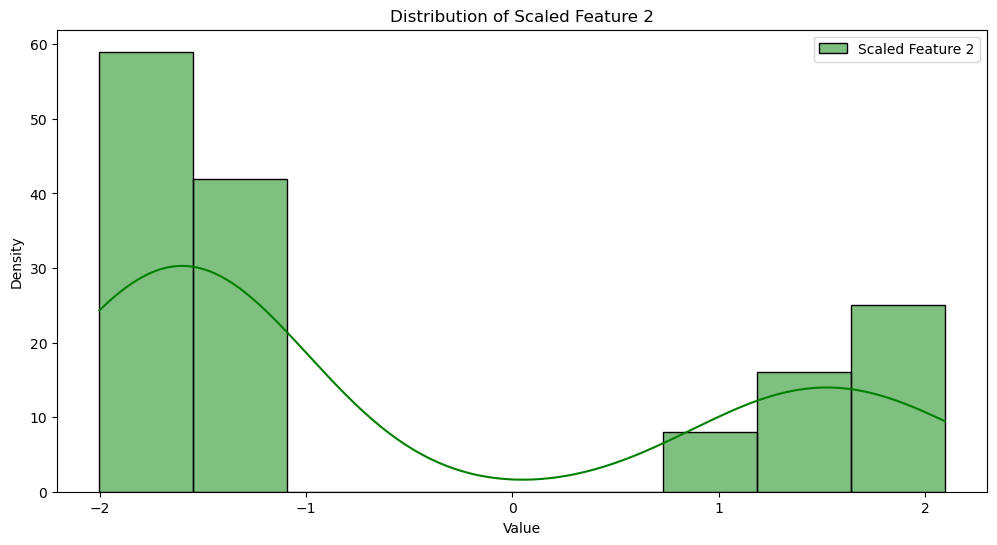

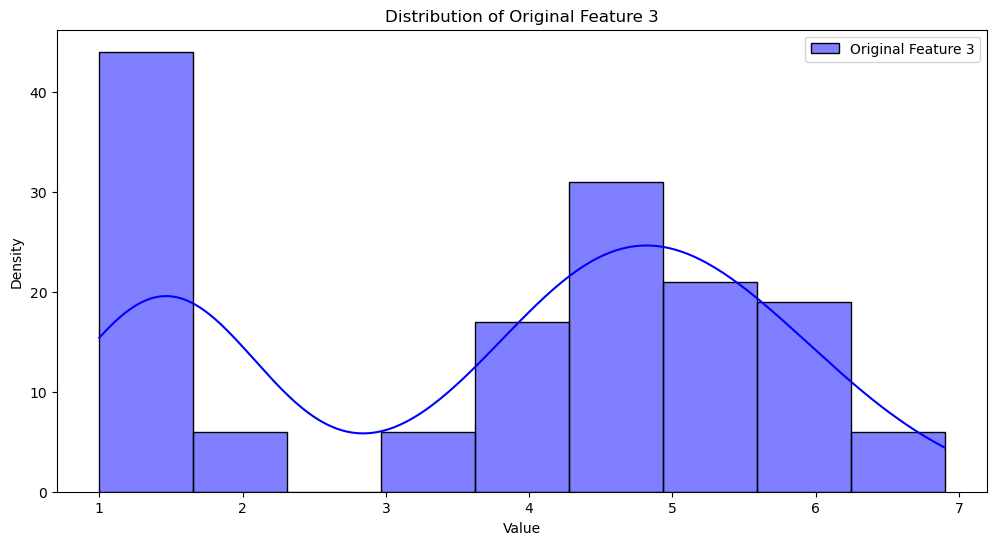

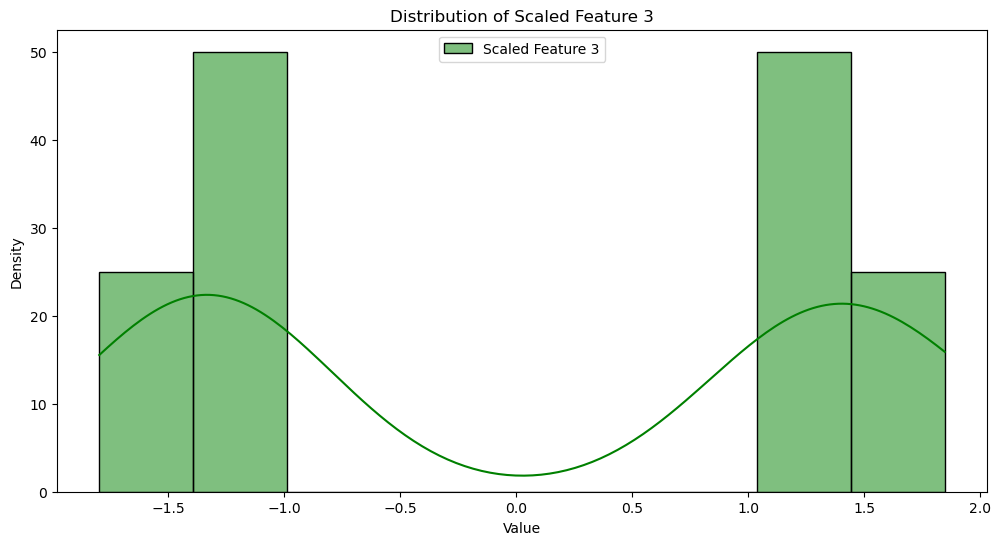

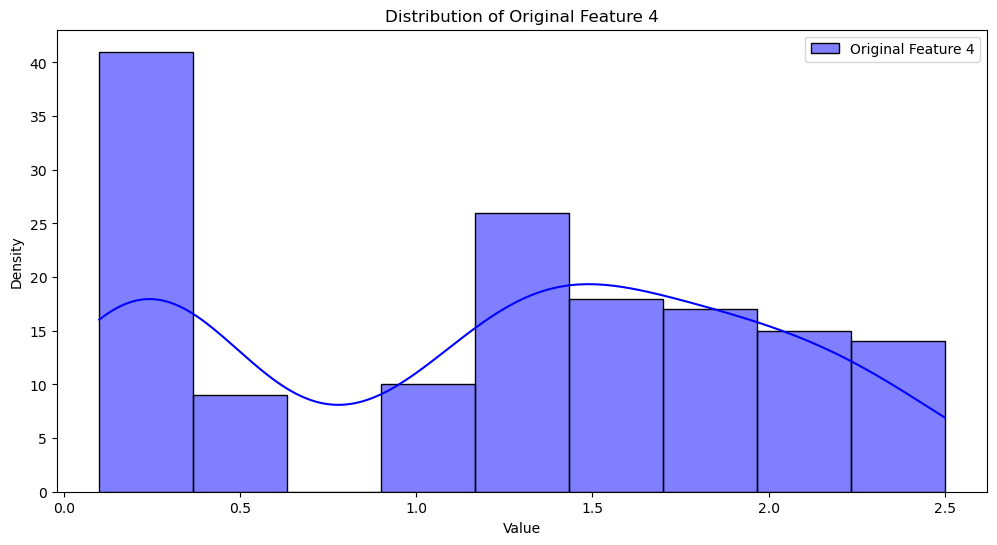

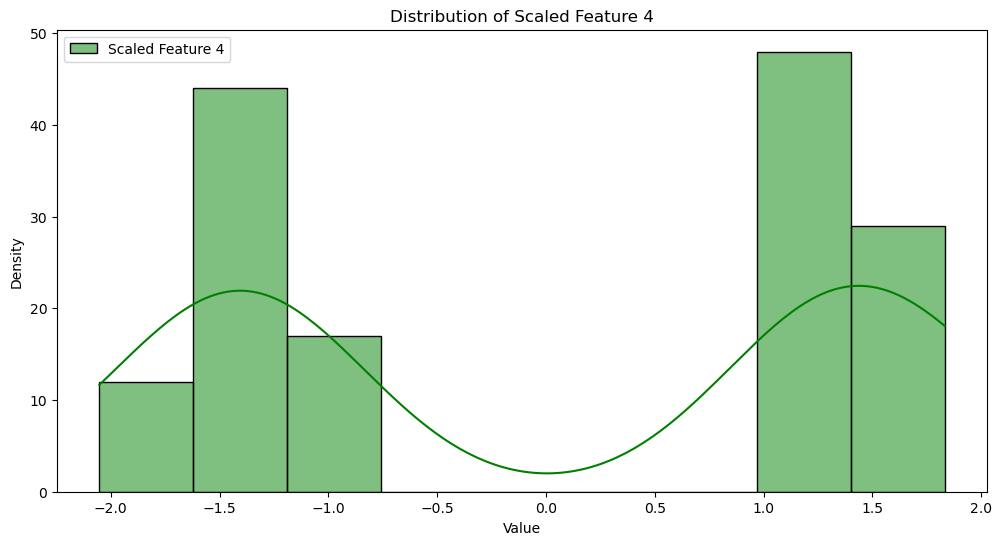

In [30]:
import matplotlib.pyplot as plt  # for plotting figures
import seaborn as sns  # for plotting histograms with KDE
import numpy as np  # for numerical operations

# Assuming features0 and features are numpy arrays
# Example usage for visualizing the distributions
for i in range(features.shape[1]):
    # Plot original feature distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(features0[:, i], kde=True, color='blue', label=f'Original Feature {i+1}')
    plt.title(f'Distribution of Original Feature {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Plot scaled feature distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(features[:, i], kde=True, color='green', label=f'Scaled Feature {i+1}')
    plt.title(f'Distribution of Scaled Feature {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [31]:
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [32]:
# import numpy as np
# from sklearn.preprocessing import StandardScaler

# def scale_data(data, train_data=None):
#   """
#   Scales data using a combination of:
#     1. Standardization (mean centering and unit variance)
#     2. Min-Max scaling to the range [-pi/2, pi/2] 
#     3. Shifting data points above/below mean by pi/4 to improve distribution

#   Args:
#     data: The data to be scaled (numpy array).
#     train_data: If provided, scaling parameters (mean and standard deviation) 
#                 are calculated from train_data and applied to both train_data and data.

#   Returns:
#     Scaled data.
#   """
#   # Print min, max, and mean of the scaled data
#   print(f"Min before: {np.min(data, axis=0)}")
#   print(f"Max before: {np.max(data, axis=0)}")
#   print(f"Mean before: {np.mean(data, axis=0)}")

#   if train_data is not None:
#     scaler = StandardScaler().fit(train_data)
#     data = scaler.transform(data)
#     train_data = scaler.transform(train_data) 
#   else:
#     scaler = StandardScaler().fit(data)
#     data = scaler.transform(data)

#   # Min-Max scaling to [-pi/2, pi/2]
#   data_min = np.min(data, axis=0)
#   data_max = np.max(data, axis=0)
#   data = (data - data_min) / (data_max - data_min) 
#   data = data - 0.5 
#   #data = data * np.pi * 2/6
#   data = data * np.pi

#   # Shift data points above/below mean by pi/4
#   mean = np.mean(data, axis=0)
#   idx_above_mean = data > mean
#   idx_below_mean = data <= mean
#   data[idx_above_mean] += np.pi / 4
#   data[idx_below_mean] -= np.pi / 4

#   # Print min, max, and mean of the scaled data
#   print(f"Min: {np.min(data, axis=0)}")
#   print(f"Max: {np.max(data, axis=0)}")
#   print(f"Mean: {np.mean(data, axis=0)}")

#   return data

# scaled_train_features = scale_data(train_features)
# scaled_test_features = scale_data(test_features, train_features)

In [33]:
# import numpy as np

# # Min-max scaling function with training stats
# def minmax_scale_to_pi_train_test(data, train_min, train_max):
#     scaled_data = (data - train_min) / (train_max - train_min)  # Scale to [0, 1]
#     scaled_data = scaled_data - 0.5
#     scaled_data = scaled_data * np.pi * 2/6
#     #scaled_data = scaled_data * np.pi * 1/2

#     return scaled_data
    

# # Compute min and max from training data
# train_min = np.min(train_features, axis=0)
# train_max = np.max(train_features, axis=0)
# # Print to verify the range
# print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
# print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

# # Scale training and test data
# train_features = minmax_scale_to_pi_train_test(train_features, train_min, train_max)
# test_features = minmax_scale_to_pi_train_test(test_features, train_min, train_max)
# print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
# print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )


# idx = train_features > np.mean(train_features)
# #train_features[idx] = train_features[idx] + np.pi / 3
# train_features[idx] = train_features[idx] + np.pi / 4 # Pretty good

# # since mean is negative, will do equal to negative
# idx = train_features <= np.mean(train_features)
# train_features[idx] = train_features[idx] - np.pi / 4

# idx = test_features > np.mean(test_features)
# test_features[idx] = test_features[idx] + np.pi / 4
# # since mean is negative, will do equal to negative
# idx = test_features <= np.mean(test_features)
# test_features[idx] = test_features[idx] - np.pi / 4

# print("train range:", np.min(train_features), "to", np.max(train_features), " mean of ", np.mean(train_features))
# print("test range:", np.min(test_features), "to", np.max(test_features), " mean of ", np.mean(test_features) )

In [34]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

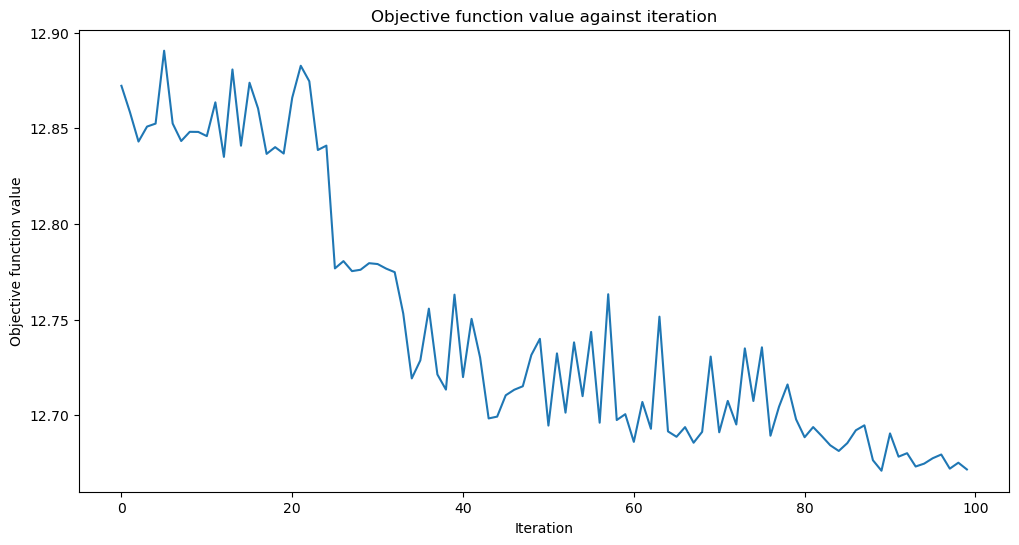

Training time: 104 seconds


In [ ]:
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, GradientDescent, CG
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.optimizers import ADAM

num_features = train_features.shape[1]
num_obs =  train_features.shape[0]
nrep = int( np.floor( num_obs * 0.2) )
feature_map = ZZFeatureMap(feature_dimension=num_features, entanglement='full', reps=4)

sampler = Sampler()

#ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
#ansatz = RealAmplitudes(num_qubits=num_features, entanglement='full', reps=1) 
ansatz = EfficientSU2(num_qubits=num_features,  entanglement='full', reps=3)
#ansatz = TwoLocal(num_qubits=num_features, rotation_blocks = ['ry','rz'], entanglement_blocks ='cz', entanglement='full', reps=1)
#ansatz = TwoLocal(num_qubits=num_features, rotation_blocks = ['ry','rz'], entanglement_blocks ='cx', entanglement='full', reps=1)
#ansatz = TwoLocal(num_qubits=num_features, rotation_blocks = ['ry','rz'], entanglement_blocks ='cry', entanglement='full', reps=2)

#optimizer = COBYLA(maxiter=100)
#optimizer = CG(maxiter=50)
optimizer = L_BFGS_B(maxiter=50)
#optimizer = GradientDescent(maxiter=100)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    loss="cross_entropy" , # absolute_error | cross_entropy |squared_error
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [36]:
train_score_q2_eff = vqc.score(train_features, train_labels)
test_score_q2_eff = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.50
Quantum VQC on the test dataset using EfficientSU2:     0.57


In [29]:
print(f"Model                           | Test Score | Train Score")
print(f"SVC, 4 features                 | {train_score_c4:10.2f} | {test_score_c4:10.2f}")
print(f"VQC, 4 features, RealAmplitudes | {train_score_q4:10.2f} | {test_score_q4:10.2f}")
print(f"----------------------------------------------------------")
print(f"SVC, 2 features                 | {train_score_c2:10.2f} | {test_score_c2:10.2f}")
print(f"VQC, 2 features, RealAmplitudes | {train_score_q2_ra:10.2f} | {test_score_q2_ra:10.2f}")
print(f"VQC, 2 features, EfficientSU2   | {train_score_q2_eff:10.2f} | {test_score_q2_eff:10.2f}")

Model                           | Test Score | Train Score
SVC, 4 features                 |       0.99 |       0.97
VQC, 4 features, RealAmplitudes |       0.62 |       0.57
----------------------------------------------------------
SVC, 2 features                 |       0.97 |       0.90
VQC, 2 features, RealAmplitudes |       0.45 |       0.20
VQC, 2 features, EfficientSU2   |       0.68 |       0.63
